This is to demonstrate how to use the `s1-enumerator` to get a full time series of GUNWs.

We are going basically take each month in acceptable date range and increment by a month and make sure the temporal window is large enough to ensure connectivity across data gaps.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from s1_enumerator import get_aoi_dataframe,  distill_all_pairs, enumerate_ifgs, get_s1_coverage_tiles, enumerate_ifgs_from_stack, get_s1_stack_by_dataframe
import concurrent
from s1_enumerator import duplicate_gunw_found
from tqdm import tqdm
from shapely.geometry import Point
import datetime
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
import networkx as nx

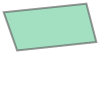

In [3]:
df_aoi = gpd.read_file('Aleutians_pathNumber95.geojson')
aoi = df_aoi.geometry.unary_union
aoi

In [4]:
df_aoi

,aoi_name,path_number,min_days_backward,month_range_lower,month_range_upper,num_neighbors_ref,geometry
0,Aleutians,95,364,6,10,3,"POLYGON Z ((-169.81786 54.53305 0.00000, -165...."
1,Aleutians,95,0,6,10,3,"POLYGON Z ((-169.81786 54.53305 0.00000, -165...."


# Parameters

In [5]:
today = datetime.datetime.now()

START_YEAR = 2016
END_YEAR = today.year
MONTHS_OF_INTEREST = [6, 7, 8, 9, 10]

In [6]:
reference_dates = [datetime.datetime(year, month, 1) 
                   for year in range(START_YEAR, END_YEAR + 1)
                   for month in MONTHS_OF_INTEREST
                   if datetime.datetime(year, month, 1) < today]
reference_dates = list(reversed(reference_dates))
reference_dates[:10]

[datetime.datetime(2021, 10, 1, 0, 0),
 datetime.datetime(2021, 9, 1, 0, 0),
 datetime.datetime(2021, 8, 1, 0, 0),
 datetime.datetime(2021, 7, 1, 0, 0),
 datetime.datetime(2021, 6, 1, 0, 0),
 datetime.datetime(2020, 10, 1, 0, 0),
 datetime.datetime(2020, 9, 1, 0, 0),
 datetime.datetime(2020, 8, 1, 0, 0),
 datetime.datetime(2020, 7, 1, 0, 0),
 datetime.datetime(2020, 6, 1, 0, 0)]

In [7]:
secondary_dates = [ref_date + relativedelta(months=1) for ref_date in reference_dates]
secondary_dates = secondary_dates[1:] + reference_dates[-1:]
secondary_dates[:10]

[datetime.datetime(2021, 10, 1, 0, 0),
 datetime.datetime(2021, 9, 1, 0, 0),
 datetime.datetime(2021, 8, 1, 0, 0),
 datetime.datetime(2021, 7, 1, 0, 0),
 datetime.datetime(2020, 11, 1, 0, 0),
 datetime.datetime(2020, 10, 1, 0, 0),
 datetime.datetime(2020, 9, 1, 0, 0),
 datetime.datetime(2020, 8, 1, 0, 0),
 datetime.datetime(2020, 7, 1, 0, 0),
 datetime.datetime(2019, 11, 1, 0, 0)]

In [8]:
path_numbers = df_aoi.path_number.unique().tolist()
path_numbers

[95]

In [9]:
df_coverage_tiles = get_s1_coverage_tiles(aoi,
                                              # the date is used to get coverage tiles for extracting stack.
                                              # Recent data has reliable coverage.
                                              start_date=datetime.datetime(2021, 1, 1))

df_stack = get_s1_stack_by_dataframe(df_coverage_tiles,
                                     path_numbers=path_numbers)

In [10]:
df_stack_month = df_stack[df_stack.start_date.dt.month.isin(MONTHS_OF_INTEREST)]

In [11]:
df_stack_month.shape

(57, 27)

In [12]:
ifg_pairs = []

for ref_date, sec_date in zip(tqdm(reference_dates), (secondary_dates)):
    min_days_backward = (ref_date - sec_date).days
    temporal_window_days=364 * 3
    temp = enumerate_ifgs_from_stack(df_stack_month,
                                     aoi,
                                     ref_date,
                                     enumeration_type='tile',
                                     min_days_backward=(ref_date - sec_date).days,
                                     num_neighbors_ref=3,
                                     num_neighbors_sec=3,
                                     temporal_window_days=temporal_window_days,
                                     )
    ifg_pairs += temp

100%|█████████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.24it/s]


In [13]:
df_pairs = distill_all_pairs(ifg_pairs)
df_pairs['reference_date'] = pd.to_datetime(df_pairs['reference_date'])
df_pairs['secondary_date'] = pd.to_datetime(df_pairs['secondary_date'])

df_pairs.head()

,reference,secondary,reference_date,secondary_date,path_number,geometry
0,[S1B_IW_SLC__1SDV_20211005T045609_20211005T045...,[S1B_IW_SLC__1SDV_20210923T045609_20210923T045...,2021-10-05,2021-09-23,95,"POLYGON ((-165.42451 52.81769, -165.42451 52.8..."
1,[S1B_IW_SLC__1SDV_20211005T045609_20211005T045...,[S1B_IW_SLC__1SDV_20210911T045609_20210911T045...,2021-10-05,2021-09-11,95,"POLYGON ((-165.42425 52.81665, -165.42425 52.8..."
2,[S1B_IW_SLC__1SDV_20211005T045609_20211005T045...,[S1B_IW_SLC__1SDV_20210830T045608_20210830T045...,2021-10-05,2021-08-30,95,"POLYGON ((-169.70385 54.20295, -169.70385 54.2..."
3,[S1B_IW_SLC__1SDV_20211017T045609_20211017T045...,[S1B_IW_SLC__1SDV_20210923T045609_20210923T045...,2021-10-17,2021-09-23,95,"POLYGON ((-165.42544 52.81760, -165.42544 52.8..."
4,[S1B_IW_SLC__1SDV_20211017T045609_20211017T045...,[S1B_IW_SLC__1SDV_20210911T045609_20210911T045...,2021-10-17,2021-09-11,95,"POLYGON ((-165.42517 52.81654, -165.42517 52.8..."


The numer of GUNWs will be the number of rows i.e.:

In [14]:
print('# of GUNWs: ', df_pairs.shape[0])

# of GUNWs:  270


# Get Date Graph

We can put this into a network Directed Graph and use some simple network functions to check connectivity.

In [15]:
list(zip(df_pairs.reference_date, df_pairs.secondary_date))[:20]

[(Timestamp('2021-10-05 00:00:00'), Timestamp('2021-09-23 00:00:00')),
 (Timestamp('2021-10-05 00:00:00'), Timestamp('2021-09-11 00:00:00')),
 (Timestamp('2021-10-05 00:00:00'), Timestamp('2021-08-30 00:00:00')),
 (Timestamp('2021-10-17 00:00:00'), Timestamp('2021-09-23 00:00:00')),
 (Timestamp('2021-10-17 00:00:00'), Timestamp('2021-09-11 00:00:00')),
 (Timestamp('2021-10-17 00:00:00'), Timestamp('2021-08-30 00:00:00')),
 (Timestamp('2021-10-29 00:00:00'), Timestamp('2021-09-23 00:00:00')),
 (Timestamp('2021-10-29 00:00:00'), Timestamp('2021-09-11 00:00:00')),
 (Timestamp('2021-10-29 00:00:00'), Timestamp('2021-08-30 00:00:00')),
 (Timestamp('2021-09-11 00:00:00'), Timestamp('2021-08-30 00:00:00')),
 (Timestamp('2021-09-11 00:00:00'), Timestamp('2021-08-18 00:00:00')),
 (Timestamp('2021-09-11 00:00:00'), Timestamp('2021-08-06 00:00:00')),
 (Timestamp('2021-09-23 00:00:00'), Timestamp('2021-08-30 00:00:00')),
 (Timestamp('2021-09-23 00:00:00'), Timestamp('2021-08-18 00:00:00')),
 (Time

In [16]:
df_pairs.reference_date.unique()[:10]

array(['2021-10-05T00:00:00.000000000', '2021-10-17T00:00:00.000000000',
       '2021-10-29T00:00:00.000000000', '2021-09-11T00:00:00.000000000',
       '2021-09-23T00:00:00.000000000', '2021-08-06T00:00:00.000000000',
       '2021-08-18T00:00:00.000000000', '2021-08-30T00:00:00.000000000',
       '2020-10-10T00:00:00.000000000', '2020-10-22T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [17]:
unique_dates = df_pairs.reference_date.tolist() + df_pairs.secondary_date.tolist()
unique_dates = sorted(list(set(unique_dates)))
unique_dates[:4]

[Timestamp('2015-07-27 00:00:00'),
 Timestamp('2015-08-20 00:00:00'),
 Timestamp('2015-10-07 00:00:00'),
 Timestamp('2016-06-03 00:00:00')]

In [18]:
date2node = {date: k for (k, date) in enumerate(unique_dates)}
node2date = {k: date for (date, k) in date2node.items()}

In [19]:
G = nx.DiGraph()

edges = [(date2node[ref_date], date2node[sec_date]) 
         for (ref_date, sec_date) in zip(df_pairs.reference_date, df_pairs.secondary_date)]
G.add_edges_from(edges)

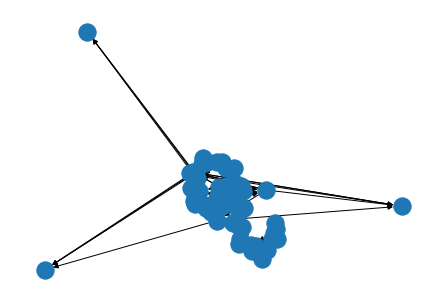

In [20]:
nx.draw(G)

In [21]:
unique_dates[0]

Timestamp('2015-07-27 00:00:00')

This function checks there is a path from the first date to the last one.

In [22]:
nx.has_path(G, 
            target=date2node[unique_dates[0]],
            source=date2node[unique_dates[-1]])

True

The y-axis is created purely for display so doesn't really indicated anything but flow by month.

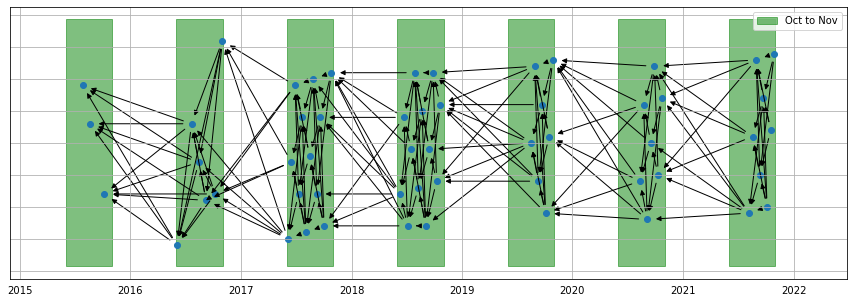

In [23]:
fig, ax = plt.subplots(figsize=(15, 5))

increment = [date.month + date.day for date in unique_dates]

# source: https://stackoverflow.com/a/27852570
scat = ax.scatter(unique_dates, increment)
position = scat.get_offsets().data

pos = {date2node[date]: position[k] for (k, date) in enumerate(unique_dates)}
nx.draw_networkx_edges(G, pos=pos, ax=ax)
ax.grid('on')
ax.tick_params(axis='x',
               which='major',
               labelbottom=True,
               labelleft=True)
ymin, ymax = ax.get_ylim()
for y in range(2015, 2022):
    label = 'Oct to Nov' if y == 2016 else None
    ax.fill_between([datetime.datetime(y, 6, 1), datetime.datetime(y, 11, 1)], 
                    ymin, ymax, 
                    alpha=.5, color='green', zorder=0, label=label)
plt.legend()